In [1]:
import sys
sys.path.append('/home/jingpei/Desktop/CtRNet-robot-pose-estimation')

import multiprocessing as mp
import os
import time

from PIL import Image

import cv2
import numpy as np
import torch

import torchvision
import matplotlib.pyplot as plt
import glob

from imageloaders.DREAM import ImageDataLoaderSynthetic


from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import kornia


from utils import *



In [2]:
import argparse
parser = argparse.ArgumentParser()

args = parser.parse_args("")

args.n_kp = 9
args.scale = 0.5
args.lim=[-1., 1., -1., 1.]
args.height = 480 
args.width = 640
args.base_dir = '/home/jingpei/Desktop/CtRNet-robot-pose-estimation'
#args.data_folder = '/media/jingpei/DATA/DREAM/data/synthetic/panda_synth_train_dr'
args.data_folder = '/media/jingpei/DATA/DREAM/data/synthetic/panda_synth_test_dr'

args.use_gpu = True
args.batch_size = 2

if args.use_gpu:
    device = "cuda"
else:
    device = "cpu"


args.fx = -320.
args.fy = -320.
args.px = 320.
args.py = 240.
# scale the camera parameters
args.width = int(args.width * args.scale)
args.height = int(args.height * args.scale)
args.fx = args.fx * args.scale
args.fy = args.fy * args.scale
args.px = args.px * args.scale
args.py = args.py * args.scale
intrinsics = np.array([[  args.fx   ,    0.        ,  args.px  ],
                       [  0.        ,    args.fy   ,  args.py  ],
                       [  0.        ,    0.        ,   1.      ]])

K = torch.tensor(intrinsics, device=device, dtype=torch.float)


In [4]:
trans_to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#torch.multiprocessing.set_start_method('spawn')

#dataset = ImageDataLoader(data_file = args.data_file, data_dir = args.data_dir, trans_to_tensor = trans_to_tensor)
#dataloader = DataLoader(dataset, batch_size=args.batch_size, num_workers= 6, shuffle=True)
dataset = ImageDataLoaderSynthetic(data_folder = args.data_folder, scale = args.scale, trans_to_tensor = trans_to_tensor)
dataloader = DataLoader(dataset, batch_size=args.batch_size, num_workers= 6, shuffle=True)

In [6]:
img, joint_angle, base_to_cam = dataset.__getitem__(666) 


# generate ground truth

In [8]:
data = next(iter(dataloader))

if args.use_gpu:
    if isinstance(data, list):
        data = [d.cuda() for d in data]
    else:
        data = data.cuda()

img, joint_angle, base_to_cam = data

In [9]:
from models.robot_arm import PandaArm
from models.BPnP import batch_project
robot = PandaArm(urdf_file = os.path.join(args.base_dir,"urdfs/Baxter/baxter_description/urdf/baxter.urdf"))

In [10]:
# generate ground truth

point_idx_list = [0,2,3,4,6,7,8]

#mask_list_gt = list()
points_2d_gt_list = list()
for b in range(img.shape[0]):
    #baxter_mesh = panda_renderer.get_robot_mesh(joint_angle[b].cpu().squeeze())
    #rendered_image = panda_renderer.silhouette_renderer(meshes_world=baxter_mesh, R = base_to_cam[b,:3,:3].T.unsqueeze(0), T = base_to_cam[b,:3,3].unsqueeze(0))
    #mask_list_gt.append(rendered_image[..., 3])

    _,t_list = robot.get_joint_RT(joint_angle[b].cpu().squeeze())

    points_3d = torch.from_numpy(t_list).float().to(device)
    points_3d = points_3d[point_idx_list]
    points_2d_gt = batch_project(base_to_cam[b,:3,:4][None], points_3d, K, angle_axis=False)
    points_2d_gt_list.append(points_2d_gt)


#mask_batch = torch.cat(mask_list_gt,0)
points_2d_gt_batch = torch.cat(points_2d_gt_list,0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


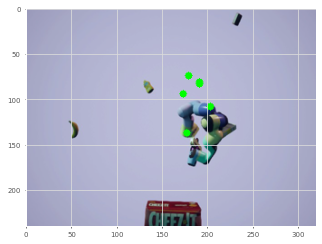

In [11]:
img_np = to_numpy_img(img[0])
img_np = overwrite_image(img_np,points_2d_gt_batch[0].detach().cpu().numpy().squeeze().astype(int), color=(0,255,0),point_size=4)
plt.imshow(img_np)

In [12]:
points_2d_gt_batch[1].detach().cpu().numpy().squeeze().astype(int)

array([[202, 214],
       [225, 185],
       [253, 134],
       [202, 214],
       [172,  51],
       [173,  56],
       [211,  52]])

# shared encoder

In [4]:
from keypoint_seg_resnet import KeyPointSegNet

keypoint_seg_predictor = KeyPointSegNet(args, use_gpu=args.use_gpu)
if args.use_gpu:
    keypoint_seg_predictor = keypoint_seg_predictor.cuda()


In [5]:
data = next(iter(dataloader))

if args.use_gpu:
    if isinstance(data, list):
        data = [d.cuda() for d in data]
    else:
        data = data.cuda()

img, joint_angle, base_to_cam = data

In [6]:
points_2d, segmentation = keypoint_seg_predictor(img)
points_2d.shape

torch.Size([2, 9, 2])

In [7]:
segmentation.shape

torch.Size([2, 1, 240, 320])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


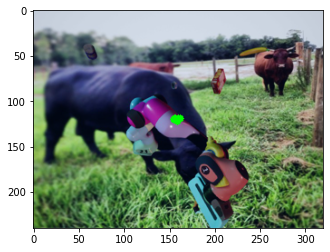

In [8]:
img_np = to_numpy_img(img[0])
img_np = overwrite_image(img_np,points_2d[0].detach().cpu().numpy().squeeze().astype(int), color=(0,255,0),point_size=4)
plt.imshow(img_np)

In [9]:
img_ref = torch.sigmoid(segmentation)
img_ref.shape

torch.Size([2, 1, 240, 320])

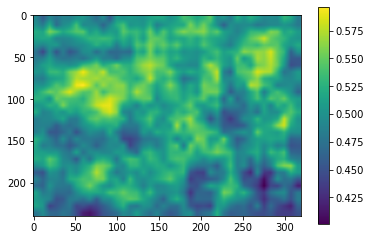

In [10]:
plt.imshow(img_ref[0].squeeze().detach().cpu().numpy())
plt.colorbar()

In [11]:
import BPnP
import kornia as kn

bpnp = BPnP.BPnP.apply
#fx = -554.25625842
#fy = -554.25625842

fx = -320. * args.scale
fy = -320. * args.scale
px =  320. * args.scale
py =  240. * args.scale
intrinsics = np.array([[fx,    0.        ,  px        ],
                    [   0.        , fy,  py       ],
                    [   0.        ,    0.        ,    1.        ]])

K = torch.tensor(intrinsics, device=device, dtype=torch.float)

In [12]:
from renderer.robot_arm import PandaArm
from renderer.mesh_renderer import RobotMeshRenderer
from pytorch3d.structures import Meshes

urdf_file = "/home/jingpei/Desktop/robot_pose_estimation/renderer/Panda/panda.urdf"
panda_arm = PandaArm(urdf_file=urdf_file)

focal_length = [-fx,-fy]
principal_point = [px, py]
image_size = [args.height,args.width]
mesh_files = ["../renderer/Panda/meshes/visual/link0/link0.obj",
              "../renderer/Panda/meshes/visual/link1/link1.obj",
              "../renderer/Panda/meshes/visual/link2/link2.obj",
              "../renderer/Panda/meshes/visual/link3/link3.obj",
              "../renderer/Panda/meshes/visual/link4/link4.obj",
              "../renderer/Panda/meshes/visual/link5/link5.obj",
              "../renderer/Panda/meshes/visual/link6/link6.obj",
              "../renderer/Panda/meshes/visual/link7/link7.obj",
              "../renderer/Panda/meshes/visual/hand/hand.obj",
             ]
            
panda_renderer = RobotMeshRenderer(
    focal_length=focal_length, principal_point=principal_point, image_size=image_size, 
    robot=panda_arm, mesh_files=mesh_files, device=device)

In [13]:
# generate ground truth
mask_list_gt = list()
points_2d_gt_list = list()
for b in range(img.shape[0]):
    baxter_mesh = panda_renderer.get_robot_mesh(joint_angle[b].cpu().squeeze())
    rendered_image = panda_renderer.silhouette_renderer(meshes_world=baxter_mesh, R = base_to_cam[b,:3,:3].T.unsqueeze(0), T = base_to_cam[b,:3,3].unsqueeze(0))
    mask_list_gt.append(rendered_image[..., 3])

    _,t_list = panda_arm.get_joint_RT(joint_angle[b].cpu().squeeze())
    points_3d = torch.from_numpy(t_list).float().to(device)
    points_2d_gt = BPnP.batch_project(base_to_cam[b,:3,:4][None], points_3d, K, angle_axis=False)
    points_2d_gt_list.append(points_2d_gt)

mask_batch = torch.cat(mask_list_gt,0)
points_2d_gt_batch = torch.cat(points_2d_gt_list,0)

/home/jingpei/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch3d/transforms/transform3d.py:800: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)


In [14]:
points_2d_gt_batch[0]

tensor([[129.3960, 149.6197],
        [121.3195, 128.0349],
        [121.3195, 128.0349],
        [115.9435,  99.4737],
        [126.9749, 110.9643],
        [195.0917, 169.5371],
        [195.0917, 169.5371],
        [215.4579, 188.9011],
        [196.0844, 205.7384]], device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'GT mask')

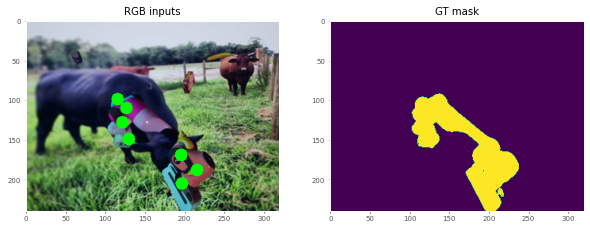

In [15]:
plt.figure(figsize=(10, 10))

img_np = to_numpy_img(img[0])
img_np = overwrite_image(img_np,points_2d_gt_batch[0].detach().cpu().numpy().squeeze().astype(int), color=(0,255,0),point_size=8)

plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.grid(False)
plt.title("RGB inputs")

plt.subplot(1, 2, 2)
plt.imshow(mask_batch[0].squeeze().cpu().detach().numpy())
plt.grid(False)
plt.title("GT mask")

2. getting 3d keypoints

In [17]:
from renderer.robot_arm import PandaArm

#urdf_file = '/home/jingpei/Desktop/robot_pose_estimation/renderer/Baxter/baxter_description/urdf/baxter.urdf'
#baxter_left_arm = BaxterLeftArm(urdf_file)

urdf_file = "/home/jingpei/Desktop/robot_pose_estimation/renderer/Panda/panda.urdf"
panda_arm = PandaArm(urdf_file=urdf_file)


In [18]:
t_batch = list()
for b in range(joint_angle.shape[0]):
    #_,t_list = baxter_left_arm.get_joint_RT(joint_angle[b].cpu().squeeze())
    _,t_list = panda_arm.get_joint_RT(joint_angle[b].cpu().squeeze())
    t_batch.append(t_list)

t_batch = np.array(t_batch)

points_3d = torch.from_numpy(t_batch).float().to(device)
points_3d.shape

torch.Size([2, 9, 3])

In [19]:
points_3d.shape

torch.Size([2, 9, 3])

3. solve for pose

In [20]:
import BPnP
import kornia as kn

bpnp = BPnP.BPnP.apply

#bpnp3d = BPnP.BPnP_m3d.apply



In [21]:
import BPnP
import kornia as kn

bpnp = BPnP.BPnP.apply
#fx = -554.25625842
#fy = -554.25625842

fx = -320.
fy = -320.
px =  320.
py =  240.
intrinsics = np.array([[fx,    0.        ,  px        ],
                    [   0.        , fy,  py       ],
                    [   0.        ,    0.        ,    1.        ]])

K = torch.tensor(intrinsics, device=device, dtype=torch.float)

In [22]:
cTb_batch = list()
points_2d_proj_batch = list()
for b in range(points_2d.shape[0]):
    cTb = bpnp(points_2d[b][None], points_3d[b], K)
    cTb_batch.append(cTb)

    points_2d_proj = BPnP.batch_project(cTb, points_3d[b], K)
    points_2d_proj_batch.append(points_2d_proj)

cTb_batch = torch.cat(cTb_batch,0)
points_2d_proj_batch = torch.cat(points_2d_proj_batch,0)

In [23]:
cTb_batch.shape

torch.Size([2, 6])

3. rendering image

In [24]:
from renderer.mesh_renderer import RobotMeshRenderer
from pytorch3d.structures import Meshes


In [36]:

focal_length = [-fx,-fy]
principal_point = [px, py]
image_size = [args.height,args.width]
mesh_files = ["renderer/S0/S0.obj", "renderer/S1/S1.obj", "renderer/E0/E0.obj", "renderer/E1/E1.obj", "renderer/W0/W0.obj", "renderer/W1/W1.obj", "renderer/W2/W2.obj"]

baxter_renderer = RobotMeshRenderer(
    focal_length=focal_length, principal_point=principal_point, image_size=image_size, 
    robot=baxter_left_arm, mesh_files=mesh_files, device=device)

In [38]:
verts_batch = list()
faces_batch = list()
for b in range(joint_angle.shape[0]):
    verts,faces = baxter_renderer.get_robot_verts_and_faces(joint_angle[b].cpu().squeeze())
    verts_batch.append(verts.to(device))
    faces_batch.append(faces.to(device))


# Create a Meshes object
robot_mesh_batch = Meshes(
    verts=verts_batch,   
    faces=faces_batch, 
)

In [39]:
R = kornia.geometry.conversions.angle_axis_to_rotation_matrix(cTb_batch[:,:3]) # (b, 3, 3)
R = torch.transpose(R,1,2)

T = cTb_batch[:,3:]   # (b, 3)
rendered_image = baxter_renderer.silhouette_renderer(meshes_world=robot_mesh_batch, R = R, T = T)
if torch.isnan(rendered_image).any():
    rendered_image = torch.nan_to_num(rendered_image)

/home/jingpei/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch3d/transforms/transform3d.py:800: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)


In [41]:
img_ref.shape

torch.Size([2, 1, 480, 640])

Text(0.5, 1.0, 'Reference silhouette')

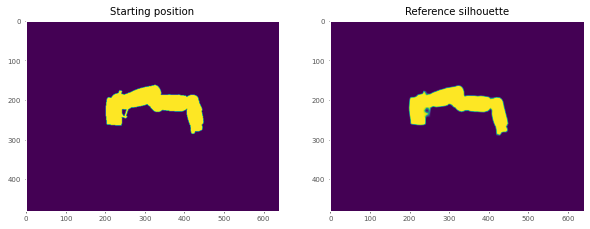

In [46]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(rendered_image[1].detach().squeeze().cpu().numpy()[..., 3])
plt.grid(False)
plt.title("Starting position")

plt.subplot(1, 2, 2)
plt.imshow(img_ref[1].squeeze().detach().cpu().numpy())
plt.grid(False)
plt.title("Reference silhouette")

In [47]:
rendered_image[..., 3].shape

torch.Size([2, 480, 640])

In [45]:
img_ref.shape

torch.Size([2, 1, 480, 640])

In [63]:
criterionMSE_sum = torch.nn.MSELoss(reduction='sum')
loss_mse = criterionMSE_sum(rendered_image[..., 3], img_ref.squeeze(1).clone().detach())
loss_mse

tensor(7239.4912, device='cuda:0', grad_fn=<MseLossBackward0>)

In [53]:
criterionMSE_mean = torch.nn.MSELoss(reduction='mean')
#loss = criterionMSE(points_2d_batch, points_2d_proj)
loss_reproj = criterionMSE_mean(points_2d, points_2d_proj_batch)
loss_reproj

tensor(7.3152, device='cuda:0', grad_fn=<MseLossBackward0>)

In [64]:
criterionBCE = torch.nn.BCEWithLogitsLoss()
loss_bce = criterionBCE(prediction.squeeze(1), rendered_image[..., 3].clone().detach())
loss_bce

tensor(0.1180, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)